# Diffusion maps using JAX backend

In this notebook, we illustrate the [diffusion maps algorithm](https://en.wikipedia.org/wiki/Diffusion_map) and Nyström out-of-sample extension with an application to data sampled on a circle embedded in the two-dimensional Euclidean space $\mathbb R^2$. 

Let $X = \mathbb R^2$, and let $M = \{ x \in X : \lVert x \rVert = 1 \}$ be the circle of unit radius centered at the origin. In what follows, we generate a training dataset consisting of points $x_0, \ldots, x_{n-1} \in M$ lying in a uniform grid. We use diffusion maps to compute eigenvalues $\lambda_0, \ldots, \lambda_{m-1}$ and corresponding eigenfunctions $\phi_0(x_i), \ldots, \phi_{m-1}(x_i)$ of a discrete integral operator that approximate the eigenvalues and eigenfunctions of the heat operator on the circle, respectively. We then apply the Nyström method to compute real-valued functions $\varphi_0(x), \ldots, \varphi_{m-1}(x)$ of $x \in X$ that extend the eigenfunctions $\phi_0(x_i), \ldots, \phi_{m-1}(x_i)$, respectively, from the training dataset $\{x_0, \ldots, x_{n-1}\} \subset M$ to the 2D Euclidean space $X$. We use $\varphi_0, \ldots, \varphi_{m-1}$ as basis functions of an $m$-dimensional approximation space (hypothesis space) to build an approximation of a function $f : M \to \mathbb R$ on the circle from its values $f(x_i)$ on the training dataset.

In this example, we use the JAX backend of the NLSA code. This will run by default on hardware accelerators (e.g., GPU, TPU) for systems that support this capability.

In [1]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

Version 1.0.5


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import os
import time
from functools import partial
from ipywidgets import interact, IntSlider
from jax import Array, grad, jit, vmap
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from nlsa.abstract_algebra2 import ldivide_by, multiply_by
from nlsa.function_algebra2 import compose, compose2
from nlsa.kernels import dm_normalize, dmsym_normalize, make_exponential_rbf,\
    make_integral_operator, make_tuning_objective
from nlsa.jax.vector_algebra import MeasureFnAlgebra, ScalarField,\
    VectorAlgebra, counting_measure, veval_at, sqeuclidean, \
    make_vector_analysis_operator, make_fn_synthesis_operator
from nlsa.jax.stats import make_von_mises_density
from numpy.typing import NDArray
from scipy.sparse.linalg import LinearOperator, eigsh
from typing import Callable, Literal, TypeVar

In [3]:
IDX_CPU = None
IDX_GPU = None
XLA_MEM_FRACTION = '.4'
F64 = False
SAVE_FIGS = False

if IDX_CPU is None and XLA_MEM_FRACTION is not None:
    # This has to come first in order to take effect.
    os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = XLA_MEM_FRACTION

match IDX_CPU, IDX_GPU:
    case int(IDX_CPU), None:
        jax.config.update("jax_default_device", jax.devices("cpu")[IDX_CPU])
    case None, int(IDX_GPU):    
        jax.config.update("jax_default_device", jax.devices("gpu")[IDX_GPU])

if F64:
    jax.config.update("jax_enable_x64", True)
    r_dtype = jnp.float64
    c_dtype = jnp.complex128
else:
    r_dtype = jnp.float32
    c_dtype = jnp.complex64

## Vectorization and Just-In-Time (JIT) compilation

We use the `vmap` and `jit` function transformations provided by the JAX library to vectorize and JIT-compile, respectively, our functions. The following convenience functions are introduced for commonly used combinations of JAX transformations. `jmap` vectorizes and JIT-compiles its input function, `vvmap` performs double vectorization (allowing functions to process 2-dimensional arrays of inputs), and `jvvmap` performs double vectorization followed by JIT compilation.

In [4]:
jvmap = compose(jit, vmap)
vvmap = compose(vmap, vmap)
jvvmap = compose(jit, vvmap)

## Type annotations

The following type aliases are used for code documentation purposes. They have not been checked against a type checker. 
- `N`: Number $n$ of training points $\theta_i$.
- `M`: Number $m$ of basis functions $\varphi_j$. This represents the dimension of the hypothesis space.
- `K`: JAX `dtype` representing scalars and array elements.
- `R`: Real numbers.
- `Rm`: Collection of $m$ real numbers.
- `X`: Data space $X \equiv \mathbb R^2$.
- `Xn`: Collection of $n$ points in $X$.
- `T1`:  Circle $\mathbb T^1$, parameterized by angle $\theta \in [0, 2 \pi)$.
- `T1n`: Collection of $n$ points in $\mathbb T^1$. 
- `V`: Vector space of real-valued functions on the circle, sampled on the training points. The dimension of `V` is given by `N`. In technical terms, `V` represents vectors in the Hilbert space $L^2(\mu_n)$, where $\mu_n = \sum_{i=0}^{n-1} \delta_{x_i}/n$ is the sampling measure associated with the training dataset.   
- `Vm`: Collection of $m$ vectors in `V`. 
- `W`: Vector space $\mathbb R^m$ of expansion coefficients in the hypothesis space. The dimension of `W` is given by `M`.   

`N` and `M` are integer literals representing the number of training samples, `n`, and number of basis functions `m`, respectively. `R`, `Rm`, `X`, `Xn`, `T1`, `T1n`, `V`, `Vm` are type aliases for JAX `Array`. `R` and `T1` are meant to be zero-dimensional. `Rm` and `W` are meant to have shape `(m,)`, `T1n` and `V` are meant to have shape `(n,)`, `X` is meant to have shape `(2,)`, `Xn` is meant to have shape `(n, 2)`, and `Vm` is meant to have shape `(n, m)` . Array shapes are currently not represented by our type annotations.     

In addition to the above, we define helper types `F[S, T]` and `Alpha`, where `F[S, T]` represents functions (`Callable`s) from type `S` to type `T`, and `Alpha` is a literal representing possible options for diffusion maps normalization (see below). 

In [5]:
N = Literal[32]
M = Literal[8]

K = jnp.float32

R = Array
Rm = Array
T1 = Array
T1n = Array
X = Array
Xn = Array
V = Array
Vm = Array
W = Array

S = TypeVar('S')
T = TypeVar('T')
F = Callable[[S], T]

Alpha = Literal['0', '0.5', '1']

## Training dataset

Our training is built from points $\theta_0, \ldots, \theta_{n-1}$ in the abstract circle $T^1$ with equispaced angle coordinates, $\theta_i = 2 \pi i / n$. We map these points into datapoints $x_0, \ldots, x_{n-1} \in M$ using the standard embedding $F : \mathbb T^1 \to \mathbb R^2$ of the circle into the 2D Euclidean space, defined as $F(\theta) = (\cos\theta,\sin\theta)$. That is, each $x_i$ is a 2-vector $x_i = (\cos\theta_i, \sin\theta_i)$. 

To numerically generate the points $x_i$ we define a function `embed_r2` that implements $F$. We vectorize this function to process multiple angles $\theta_i$ using `vmap`. We JIT-compile the vectorized `embed_r2` using `jit` for enhanced performance.  

In [6]:
@jit
@vmap
def embed_r2(theta: T1) -> X:
    """Embed points in the circle into R2."""
    return jnp.array([jnp.cos(theta), jnp.sin(theta)])

In [7]:
n: N = 2**5
thetas: T1n = jnp.linspace(0, 2 * jnp.pi, n)
xs: Xn = embed_r2(thetas)

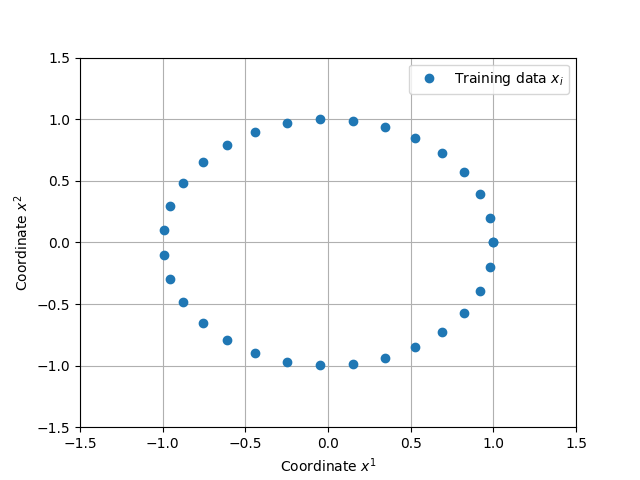

In [8]:
i_fig = 1
if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig1, ax1 = plt.subplots(num=i_fig)
ax1.plot(xs[:, 0], xs[:, 1], 'o', label='Training data $x_i$')
ax1.set_xlim([-1.5, 1.5])
ax1.set_ylim([-1.5, 1.5])
ax1.grid()
ax1.legend()
ax1.set_xlabel('Coordinate $x^1$')
ax1.set_ylabel('Coordinate $x^2$');

## Vector space of discretely sampled functions

Associated with the training dataset $\{ x_0, \ldots, x_{n-1} \}$ is an $n$-dimensional vector space $V$ consisting of equivalence classes of functions $f: X \to \mathbb R$ with common values at the points $x_0, \ldots, x_{n-1}$. We can represent the elements of $V$ as $n$-vectors $v = (v_0, \ldots, v_{n-1})$ with entries given by the values of $f$ on the training data, $v_i = f(x_i)$. We equip $V$ with the inner product $\langle u, v \rangle = \sum_{i=0}^{n-1} u_i v_i / n$. For this choice of inner product, $V$ is identified with the Hilbert space $L^2(\mu_n)$ associated with the sampling measure $\mu_n$ mentioned above. That is, we have
$$
    \langle u, v \rangle = \int_{X} e f \, d\mu_n = \frac{1}{n} \sum_{i=0}^{n-1} e(x_i) f(x_i),
$$
where $e : X \to \mathbb R$ and $f : X \to \mathbb R$ are any two functions in the equivalence classes represented by $u$ and $v$, respectively. 

Let $\mathcal F(X, \mathbb R)$ denote the vector space of real-valued functions on $X$. An important map that we will be using below is the *inclusion map* $\iota : \mathcal F(X, \mathbb R) \to V$, defined as $\iota f = v$ with $v= (f(x_0), \ldots, f(x_{n-1}))$. Note that $\iota$ maps functions on $X$ to their corresponding equivalence class in $V$. In the cell below, we implement $\iota$ as a vectorized evaluation map, `inclusion_map`, obtained using the vectorized evaluation function `veval_at` from the `nlsa.jax.vector_algebra` module. We also introduce an object `ell2` of type `MeasureFnAlgebra` (again from `nlsa.jax.vector_algebra`) that implements the Hilbert space operations and inclusion map associated with $L^2(\mu_n)$. Note that in the construction of `ell2`, instead of using the sampling measure (which is normalized by the number of samples `n`) we use the unnormalized counting measure $\hat \mu_n = \sum_{i=0}^{n-1} \delta_{x_i}$ passed through the keyword argument `measure`. It turns out that for the eigenvector computations performed below normalization by $n$ does not play a role so we can work with the numerically cheaper `counting_measure`.    

In [9]:
dtype = jnp.float32
inclusion_map: Callable[[F[X, R]], V] = veval_at(xs)
ell2: MeasureFnAlgebra[X, N, K] =\
    MeasureFnAlgebra(dim=n,
                     dtype=dtype,
                     inclusion_map=inclusion_map,
                     measure=counting_measure)

## Kernel integral operators

Given a kernel function $k: X \times X \to \mathbb R$ on data space, there is an associated *kernel integral operator* $K: V \to \mathcal F(X, \mathbb R)$ that maps vectors in $V$ to real-valued functions on the data  space $X$. This operator is defined as $g = K v$, where $v = (v_0, \ldots, v_{n-1})$ and 
$$
    g(x) = \frac{1}{n} \sum_{i=0}^{n-1} k(x,x_i) v_i.
$$
Note that if $f : X \to \mathbb R$ is a function that lies in the equivalence class represented by $v$ (i.e., $f(x_i) = v_i$) we have
$$
    g(x) = \int_X k(x,y) f(y) \, d\mu_n(y),
$$
which justifies calling $K$ an integral operator.

Pre-composing $K$ with the inclusion map, we get an operator $\tilde K : V \to V$ with $\tilde K = \iota \circ K$ that maps $V$ into itself. In particular, we can compute eigenvalues and eigenvectors associated with $\tilde K$, 
$$
    \tilde K u_j = \tilde \lambda_j u_j.
$$

Henceforth, we will assume that $k$ is symmetric, $k(x,y) = k(y,x)$ for all $x,y \in X$, which is sufficient to guarantee that $\tilde K$ has $n$ real eigenvalues, $\tilde \lambda_0, \ldots, \tilde \lambda_{n-1}$ (possibly with mutiplicities), and the corresponding eigenvectors $u_0, \ldots, u_{n-1}$ form an orthonormal basis of $V$. Note that solving the eignvalue problem for $\tilde K$ is equivalent to solving the eigenvalue problem for the $n \times n$ kernel matrix $\mathbf K = [k(x_i, x_j)]$. That is, we have $\mathbf K u_j = \tilde \lambda_j u_j$, where we treat $u_j$ as a column vector in $\mathbb R^n$. Note that normalizing $u_j$ to unit norm on $L^2(\mu_n)$ is equivalent to the normalization condition $\lVert u_j \rVert_2 = \sqrt{n}$, where $\lVert \cdot \rVert_2$ is the standard 2-norm on vectors. If, in addition, the kernel $k$ is positive-definite (i.e., $\mathbf K$ is a positive-definite matrix for every finite datasets $\{x_0, \ldots, x_{n-1}\} \subset X$), the eigenvalues are all positive, $\tilde\lambda_j \geq 0$. 

In kernel methods for machine learning, it is common to use eigendecomposition of kernel matrices for feature extraction. For instance, each eigenvector $u_j = (u_{0,j}, \ldots, u_{n-1,j}) \in V$ defines a real-valued feature, $x_i \mapsto u_{i,j}$ on the finite dataset $ \{ x_0, \ldots, x_{n-1}\} \subset X$. As we will see below, feature vectors such as $u_j$ can be extended to everywhere-defined functions on $X$ that can be used as basis functions in supervised learning algorithms.

In the example below, we will work with the Gaussian radial basis function (RBF) kernel, $k_\epsilon : X \times X \to \mathbb R_+$, where
$$
    k_\epsilon(x,y) = \exp\left( - \frac{\lVert x - y \rVert^2_2}{\epsilon^2} \right), 
$$
and $\epsilon$ is a positive lengthscale parameter (sometimes called kernel bandwidth). The Gaussian RBF is clearly symmetric and can be shown to be positive-definite.

We implement $k_\epsilon$ as a function `k` given as a composition $k_\epsilon = h_\epsilon \circ d^2$ of the exponential shape function, $h_\epsilon : \mathbb R \to \mathbb R$, $h_\epsilon(t) = e^{-\lvert t \rvert / \epsilon^2}$ (implemented as `rbf`) with the square Euclidean distance function $d^2 : X \times X \to \mathbb R$, $d(x,y) = \lVert x - y \rVert^2$ (implemented as `sqdist`). 

## Kernel tuning

A pertinent issue with bandwidth-parameterized kernels such as $k_\epsilon$ above is how to select an "optimal" value for the bandwidth parameter $\epsilon$. In what follows, we employ a tuning approach introduced by [Coifman et al. (2008)](https://dx.doi.org/10.1109/TIP.2008.2002305) and further studied by [Berry & Harlim 2016](http://dx.doi.org/10.1016/j.acha.2015.01.001) in the context of variable-bandwidth kernels.

This approach is based on a scaling analysis of the function $T: \mathbb R \to \mathbb R$ where
$$
    T(\epsilon) = \int_X K_\epsilon \mathbf 1(x) \, d\mu_n(x), 
$$
where $\mathbf 1 = (1, \ldots, 1) \in V$ is the vector with contant entries equal to 1 and $K_\epsilon : V \to \mathcal F(X,\to\mathbb R)$ is the integral operator associated with $k_\epsilon$. Scaling arguments of Coifman et al. (2008) show that for a well-tuned kernel the logarithimic derivative
$$
    \hat d(\epsilon) := 2 \times \frac{d \log T(\epsilon)}{d\log\epsilon}
$$
should be close to the dimension of the manifold $M \subset X$ where the sampling distribution of the data is supported (in our example, $M$ has dimension 1). In situations where the dimension of $M$ is not known a priori, Berry et al. (2016) recommend choosing $\epsilon$ as the maximizer of $\hat d(\epsilon)$ over a range of trial values of $\epsilon$. In particular, they find that, experimentally, the maximum of $\hat d(\epsilon)$ is oftentimes close to the dimension of $M$. This suggests that $\hat d(\epsilon)$ can be interpreted as an effective dimension of $M$ for the lengthscale $\epsilon$, and we should choose $\epsilon$ such that the effective dimension of $M$ is maximized.     

While this is generally a good strategy, in the example below we will see that $\hat d_\epsilon$ can exhibit maxima away from the true manifold dimension, so this approach should be used with caution. 

In the cell below, we implement $\hat d(\epsilon)$ as the function `k_tune` built using the `make_tuning_objective` function from the `nlsa.kernels` module. `make_tuning_objective` uses JAX's `grad` function to compute the logarithmic derivative of $T(\epsilon)$ via automatic differentiation. We evaluate `k_tune` on a uniform grid of $\log_{10}(\epsilon)$ values and plot the results.

In [10]:
n_bandwidth: int = 32
log10_bandwidth_lims: tuple[float, float] = (-3., 3.)

sqdist = sqeuclidean
log10_bandwidths = jnp.linspace(log10_bandwidth_lims[0],
                                log10_bandwidth_lims[1], n_bandwidth)
scl = ScalarField(dtype=dtype)
shape_func = partial(make_exponential_rbf, scl)

def k_func(epsilon: R) -> Callable[[X, X], R]:
    return  compose(shape_func(epsilon), sqdist)

k_tune = jit(make_tuning_objective(ell2, k_func, grad))
start_time = time.perf_counter()
est_dims = jnp.array([k_tune(epsilon) for epsilon in log10_bandwidths])
i_opt = jnp.argmax(est_dims)
bandwidth = 10. ** log10_bandwidths[i_opt]
end_time = time.perf_counter()

print(f"Kernel tuning took {end_time - start_time:.3e} s")
print(f"Optimal bandwidth index: {i_opt}")
print(f"Optimal bandwidth: {bandwidth:.3e}")
print(f"Estimated dimension: {est_dims[i_opt]:.3e}")

Kernel tuning took 5.945e-01 s
Optimal bandwidth index: 16
Optimal bandwidth: 1.250e+00
Estimated dimension: 1.183e+00


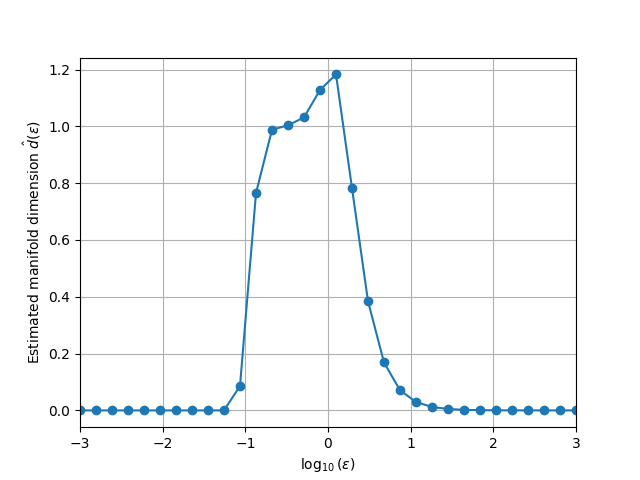

In [11]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig2, ax2 = plt.subplots(num=i_fig)
ax2.plot(log10_bandwidths, est_dims, 'o-')
ax2.set_xlim(log10_bandwidth_lims)
ax2.grid()
ax2.set_xlabel(r'$\log_{10}(\epsilon)$')
ax2.set_ylabel(r'Estimated manifold dimension $\hat d(\epsilon)$');

In Figure 2, we see that while $\hat d(\epsilon)$ exhibits a plateau near the intrinsic dimension $\mathrm{dim} M = 1$, for larger values of $\log_{10}(\epsilon)$ it develops a "bump" to $\hat d(\epsilon) \approx 1.2$. The bump is possibly caused by the embedding of $M$ into $\mathbb R^2$. In particular, for embedded manifolds of low comdimension (here, $\mathrm{codim} M := \mathrm{dim} X - \mathrm{dim} M = 1$) the dimension estimate $\hat d(\epsilon)$ can be larger than the intrinsic dimension as the integral 
$$
T(\epsilon) = \int_X \int_X k_\epsilon(x,y) \, d\mu_n(y)\, d\mu_n(x)
$$
may be significantly influenced by values of the integrand $k_\epsilon(x,y)$ away from the diagonal $y=x$. In the computations that follow, we select $\epsilon = 0.1$ so that $\hat d(\epsilon)$ is close to the intrinsic dimension $\mathrm{dim} M = 1$. 

In [12]:
epsilon = 0.3
rbf = make_exponential_rbf(scl, epsilon)
k: Callable[[X, X], R] = compose(rbf, sqdist)

## Diffusion maps

Suppose that the kernel $k_\epsilon : X \times X \to \mathbb R_+$ is strictly positive-valued, i.e., $k(x,y) > 0 $ for all $x, y \in X$. Rather than working with the "raw" kernel $k_\epsilon$, the diffusion maps algorithm employs a normalized kernel $p_\epsilon : X \times X \to \mathbb R_+$ that is derived from $k_\epsilon$ and has the Markov property with respect to the sampling measure of the data:
$$
    \frac{1}{n} \sum_{i=0}^{n-1} p_\epsilon(x, x_i) = 1, \quad \forall x \in X.
$$

Let $\mathbf 1 = (1, \ldots, 1)$ be the vector in $V$ with constant entries equal to 1. Let $\alpha$ be a real parameter. Diffusion maps builds the kernel $p_\epsilon$ through the following sequence of steps:
1. Using the integral operator $K_\epsilon : V \to \mathcal F(X, \mathbb R)$, compute the function $q_\epsilon = K_\epsilon \mathbf 1$.
2. Define the kernel $\hat k_\epsilon : X \times X \to \mathbb R_+$ with $$ \hat k_\epsilon(x,y) = \frac{k_\epsilon(x,y)}{(q_\epsilon(x)q_\epsilon(y))^\alpha}.$$
3. Using the integral operator $\hat K_\epsilon : V \to \mathcal F(X,\mathbb R)$ associated with $\hat k_\epsilon$, define the function $d_\epsilon = \hat K_\epsilon \mathbf 1$.
4. Define the Markov kernel $p_\epsilon : X \times X \to \mathbb R$ with $$p_\epsilon(x,y) = \frac{\hat k_\epsilon(x,y)}{d_\epsilon(x)}.$$

Next, let $G_\epsilon = \iota \circ P_\epsilon : V \to V $ and define the operator 
$$
    L_\epsilon = 4 \frac{(I - G_\epsilon)}{\epsilon^2},
$$
where $I: V \to V$ is the identiy operator. It can be shown that as $\epsilon \to 0 $, $L_\epsilon$ approximates the generator of a diffusion process on $M$ that depends on $\alpha$. Two common choices used in the literature are: 
- $\alpha = 1$: $L_\epsilon$ approximates the Laplace operator on $M$ (generator of Brownian motion).
- $\alpha = 1/2$: $L_\epsilon$ approximates the generator of a gradient flow for a potential that depends on the density of the sampling distribution of the data relative to the Riemannian volume form on $M$.   

Below, we use the `dm_normalize` function from the `nlsa.kernels` module to build the Markov kernel $p_\epsilon$ as a function `p` for $\alpha = 1$ from the Gaussian kernel `k`. We use the `make_integral_operator` function from the same module to build an implementation `p_op` of the integral operator $P_\epsilon$ associated with $p_\epsilon$. 

In [13]:
alpha: Alpha = '1'
p: Callable[[X, X], R] = dm_normalize(ell2, alpha, k)
p_op: Callable[[V], F[X, R]] = make_integral_operator(ell2, p)

We visualize the action of `p_op` on a vector `v` obtained by sampling the derivative of a von Mises probability density function on $\mathbb T^1$ on the angles $\theta_i$ underlying the datapoints $x_i$. We use this function as an example with strongly oscillatory behavior near $\theta = \pi$ that highlights the averaging behavior of `p_op`. In Figures 2 and 3, we plot the resulting function `f_p = p_op(v)` as a function of angle $\theta$ on the circle and as a scatterplot on $\mathbb R^2$, respectively. Notice the averaging effect of $P_\epsilon$ near the points with polar coordinate $\theta = \pi$.       

In [14]:
kappa = 20.
von_mises = make_von_mises_density(kappa, jnp.pi)
f: F[T1, R] = jvmap(grad(von_mises))
v = f(thetas)
f_p = p_op(v)

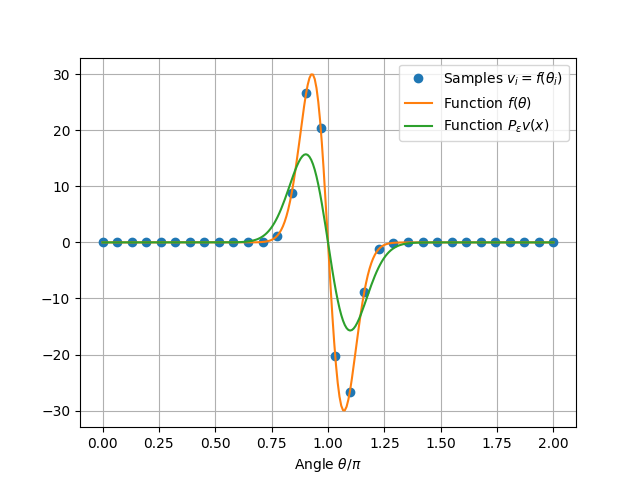

In [15]:
n_theta_plt = 256
thetas_plt = jnp.linspace(0, 2 * jnp.pi, n_theta_plt)
xs_circle_plt = embed_r2(thetas_plt)
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig3, ax3 = plt.subplots(num=i_fig)
ax3.plot(thetas / jnp.pi, v, 'o',
         label=r'Samples $v_i = f(\theta_i)$')
ax3.plot(thetas_plt / jnp.pi, f(thetas_plt), '-',
         label=r'Function $f(\theta)$')
ax3.plot(thetas_plt / jnp.pi, jvmap(f_p)(xs_circle_plt), '-',
         label=r'Function $P_\epsilon v(x)$')
ax3.set_xlabel(r'Angle $\theta/\pi$')
ax3.legend()
ax3.grid();

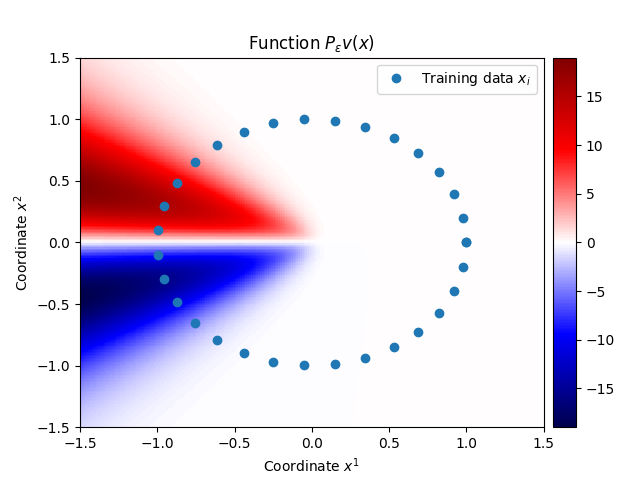

In [16]:
n_x_plt = 256
i_fig = 4
x1_plt, x2_plt = jnp.meshgrid(jnp.linspace(-1.5, 1.5, n_x_plt),
                              jnp.linspace(-1.5, 1.5, n_x_plt))
xs_plt = jnp.concatenate((x1_plt[:-1, :-1, jnp.newaxis],
                          x2_plt[:-1, :-1, jnp.newaxis]), 
                         axis=2)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig4, ax4 = plt.subplots(num=i_fig)
ax4_divider = make_axes_locatable(ax4)
cax4 = ax4_divider.append_axes("right", size="5%", pad="2%")
im4 = ax4.pcolormesh(x1_plt, x2_plt, jvvmap(f_p)(xs_plt), cmap="seismic")
cb4 = fig4.colorbar(im4, cax=cax4)
ax4.plot(xs[:, 0], xs[:, 1], 'o', label='Training data $x_i$')
ax4.set_xlabel('Coordinate $x^1$')
ax4.set_ylabel('Coordinate $x^2$')
ax4.legend()
ax4.set_title(r'Function $P_\epsilon v (x)$');

## Eigendecomposition

In general, the Markov kernels $p_\epsilon$ introduced above are not symmetric, which means that the operator $G_\epsilon$ is generally not self-adjoint. Nonetheless, we can relate $G_\epsilon$ to a self-adjoint operator $H_\epsilon : V \to V$ by a similarity transformation, as follows. 

With $d_\epsilon$ as above, define the symmetric kernel $s_\epsilon : X \times X \to \mathbb R_+$, where 
$$
    s_\epsilon(x,y) = \sqrt{d_\epsilon(x)} p_\epsilon(x, y) \frac{1}{\sqrt{d_\epsilon(y)}} = \frac{\hat k_\epsilon(x, y)}{\sqrt{d_\epsilon(x) d_\epsilon(y)}}.
$$
Let $S_\epsilon : V \to \mathcal F(X, \mathbb R)$ be the integral operator associated to $s_\epsilon$ and $H_\epsilon = \iota \circ S_\epsilon$. Since $s_\epsilon$ is symmetric, we have that $H_\epsilon$ is self-adjoint, and thus admits an eigendecomposition
$$
    H_\epsilon u_j = \lambda_j u_j, \quad j \in \{0, \ldots, n-1\},
$$
where the eigenvalues $\lambda_j$ are real and the eigenvectors $u_j$ form an orthonormal basis of $V$. 

One can directly verity that if the initial kernel $k_\epsilon$ is positive-definite and bounded away from zero (e.g., the Gaussian RBF kernel), then $s_\epsilon$ is also positive-definite and we have $\lambda_j \geq 0$. We will assume throughout that this is the case and order the eigenvalues $\lambda_j $ in decreasing order, $\lambda_0 \geq \lambda_1 \geq \cdots \geq \lambda_{n-1} \geq 0$.

Let $D_\epsilon : V \to V$ be the operator defined as 
$$
    D_\epsilon (v_0,\ldots, v_{n-1}) = (d_\epsilon(x_0) v_0, \ldots, d_\epsilon(x_{n-1}) v_{n-1});
$$
i.e., $D_\epsilon$ is a multiplication operator that multiplies vectors in $V$  elementwise by the discretely sampled function $d_\epsilon(x_i)$ on the training data. We have 
$$
    G_\epsilon = D_\epsilon^{-1/2} H_\epsilon D_\epsilon^{1/2},
$$
which means that $G_\epsilon$ and $H_\epsilon$ are related by a similarity transformation induced by $D_\epsilon$. As a result, $G_\epsilon$ admits an eigendcomposition
$$
    G_\epsilon \phi_j = \lambda_j \phi_j, \quad \phi_j = D_\epsilon^{-1/2} u_j.
$$
In particular, the eigenvectors $\phi_j$ form a basis of $V$, and since $G_\epsilon$ is a Markov operator the maximal eigenvalue $\lambda_0$ is equal to 1. Moreover, we can chose the corresponding eigenvector as $\phi_0 = (1, \ldots, 1)$. This choice implies 
$$ 
    u_0 = (u_{0,0}, \ldots, u_{n-1,0)}) = (d_\epsilon^{1/2}(x_0), \ldots, d_\epsilon^{1/2}(x_{n-1})),
$$
and thus
$$
    \phi_j = (\phi_{0,j}, \ldots, \phi_{n-1,j}) = \left( \frac{u_{0,j}}{u_{0,0}}, \ldots, \frac{u_{n-1,j}}{u_{n-1,0}} \right).
$$
The basis $\{\phi_0, \ldots, \phi_{n-1}\}$ of $V$ has a dual (biorthonormal) basis $\{\phi'_0, \ldots, \phi'_{n-1})$ satisfying $\langle \phi'_i, \phi_j \rangle_V = \delta_{ij}$, where
$$
    \phi'_i = D_\epsilon^{1/2} u_j = (u_{0,j} u_{0,0}, \ldots, u_{n-1,j}u_{n-1,0}).
$$

Below, we solve the eigenvalue problem for $H_\epsilon$ using the iterative solver `eigsh` from SciPy. In this computation, we represent $H_\epsilon$ by a function `h_op` rather than a matrix. This function is built by applying the `dmsym_normalize` function for symmetric diffusion maps normalization provided by the `nlsa.kernels` module to the un-normalized kernel $k_\epsilon$. This gives a symmetric kernel function `s` that implements $s_\epsilon$ and we build the corresponding integral operator `s_op` using `make_integral_operator` as above. We also use $L_\epsilon$ to compute approximations of Laplacian eigenvalues as $\eta_j = 4 (1-\lambda_j) / \epsilon^2$.

In [17]:
m_eigs: int = 20
m: M = m_eigs

s: Callable[[X, X], R] = dmsym_normalize(ell2, alpha, k)
s_op: Callable[[V], F[X, R]] = make_integral_operator(ell2, s)
h_op: F[V, V] = compose(veval_at(xs), s_op)
a = LinearOperator(shape=(n, n), dtype=dtype, matvec=jit(h_op))

start_time = time.perf_counter()
unsorted_evals: Rm
unsorted_evecs: Vm
unsorted_evals, unsorted_evecs = eigsh(a, m_eigs, which='LA')
end_time = time.perf_counter()
print(f'Eigendecomposition took {end_time - start_time:.3e} s')

isort = jnp.argsort(unsorted_evals)
lambs = unsorted_evals[isort[::-1]]
etas = 4. * (1. - lambs) / epsilon**2
us = unsorted_evecs[:, isort[::-1]]
from_sym: F[Vm, Vm] = jit(vmap(ldivide_by(ell2, us[:, 0]),
                               in_axes=1, out_axes=1))
dual_from_sym: F[Vm, Vm] = jit(vmap(multiply_by(ell2, us[:, 0]),
                                    in_axes=1, out_axes=1))
phis = from_sym(us)
phi_duals = dual_from_sym(us)
print('First 5 Laplacian eigenvalues:')
print(etas[0:5])

Eigendecomposition took 1.903e-01 s
First 5 Laplacian eigenvalues:
[-5.2981904e-06  1.0052733e+00  1.0076894e+00  3.8083208e+00
  3.9593854e+00]


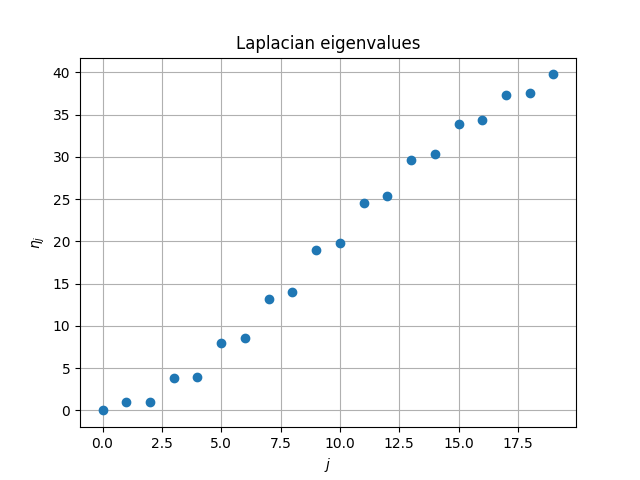

In [18]:
m_eig_plt = m_eigs
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig5, ax5 = plt.subplots(num=i_fig)
ax5.cla()
ax5.plot(jnp.arange(0, m_eig_plt), etas[0 : m_eig_plt], 'o')
ax5.grid()
ax5.set_xlabel('$j$')
ax5.set_ylabel('$\\eta_j$')
ax5.set_title('Laplacian eigenvalues');

interactive(children=(IntSlider(value=1, continuous_update=False, description='j', max=19), Output()), _dom_cl…

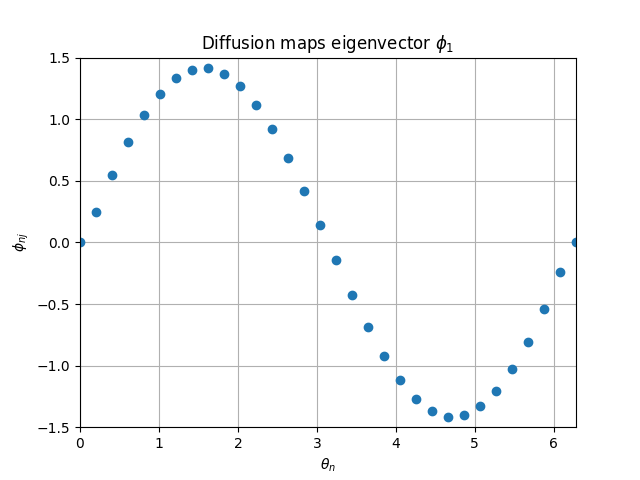

In [19]:
i_fig = 6

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig6, ax6 = plt.subplots(num=i_fig)
j_slider6 = IntSlider(value=1, min=0, max=m_eig_plt - 1, continuous_update=False)

@interact(j=j_slider6)
def plot_phi(j):
    ax6.cla()
    ax6.plot(thetas, phis[:, j], 'o')
    ax6.grid()
    ax6.set_xlabel('$\\theta_n$')
    ax6.set_ylabel('$\\phi_{nj}$')
    ax6.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 
    ax6.set_xlim(0, 2 * jnp.pi)
    ax6.set_ylim(-1.5, 1.5)

interactive(children=(IntSlider(value=1, continuous_update=False, description='j', max=19), Output()), _dom_cl…

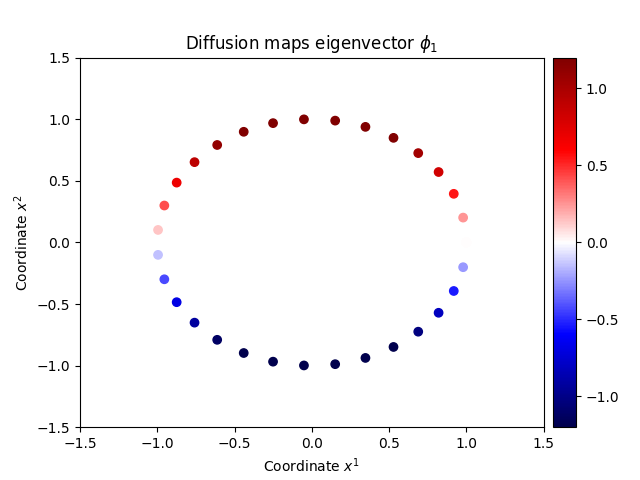

In [20]:
i_fig = 7

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig7, ax7 = plt.subplots(num=i_fig)
ax7_divider = make_axes_locatable(ax7)
cax7 = ax7_divider.append_axes("right", size="5%", pad="2%")
j_slider7 = IntSlider(value=1, min=0, max=m_eig_plt - 1, continuous_update=False)

@interact(j=j_slider7)
def plot_phi(j):
    ax7.cla()
    sc = ax7.scatter(xs[:, 0], xs[:, 1], c=phis[:, j], vmin=-1.2, vmax=1.2,
                     cmap="seismic")
    cb7 = fig7.colorbar(sc, cax=cax7)
    ax7.set_xlabel('Coordinate $x^1$')
    ax7.set_ylabel('Coordinate $x^2$')
    ax7.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 
    ax7.set_xlim(-1.5, 1.5)
    ax7.set_ylim(-1.5, 1.5)

## Out-of-sample extension

Consider the eigenbasis $\{\phi_0, \ldots, \phi_{n-1}\}$ of $V$ associated with $G_\epsilon$. For every eigenvector $\phi_j$ with nonzero corresponding eigenvalue $\lambda_j$, we define the function $\varphi_j : X \to \mathbb R$ as 
$$
    \varphi_j(x) = \frac{1}{\lambda_j} P_\epsilon \phi_j(x) = \frac{1}{\lambda_j n} \sum_{i=0}^{n-1} p_\epsilon(x,x_i) \phi_{i,j}.
$$
One can verify from the above definition that $\varphi(x_i) = \phi_{i,j}$ for every training datapoint $x_0, \ldots, x_{n-1}$. This means that $\varphi_j$ lies in the equivalence class of functions represented by $\phi_j$, i.e., $\iota\varphi_j = \phi_j$. In other words, viewing $\phi_j$ as a function $x_i \mapsto \phi_{i,j}$ on the dataset $ \{x_0, \ldots, x_{n-1} \} \subset X$, we have that $\varphi_j$ is an *extension* of $\phi_j$. 

Below we visualize the functions $\varphi_j$ for the eigenvectors shown in Figure 6.

interactive(children=(IntSlider(value=1, continuous_update=False, description='j', max=19), Output()), _dom_cl…

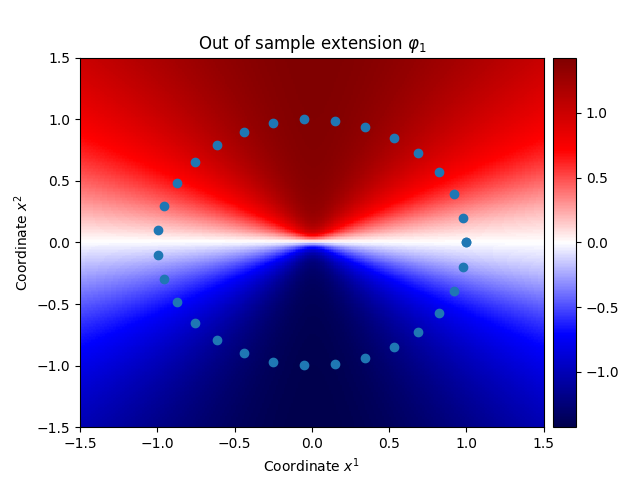

In [21]:
phi_exts = map(jvvmap,
               map(p_op, [phis[:, j]/lambs[j] for j in range(0, m_eigs)]))
phi_exts_plt = take(m_eig_plt, phi_exts)
i_fig = 8

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig8, ax8 = plt.subplots(num=i_fig)
ax8_divider = make_axes_locatable(ax8)
cax8 = ax8_divider.append_axes("right", size="5%", pad="2%")
j_slider8 = IntSlider(value=1, min=0, max=m_eig_plt - 1, continuous_update=False)

@interact(j=j_slider8)
def plot_phi(j):
    ax8.cla()
    ax8.plot(xs[:, 0], xs[:, 1], 'o', label='$x_i$')
    im = ax8.pcolormesh(x1_plt, x2_plt, phi_exts_plt[j](xs_plt),
                        cmap="seismic")
    cb8 = fig8.colorbar(im, cax=cax8)
    ax8.set_xlabel('Coordinate $x^1$')
    ax8.set_ylabel('Coordinate $x^2$')
    ax8.set_title(f'Out of sample extension $\\varphi_{{{j}}}$') 
    ax8.set_xlim(-1.5, 1.5)
    ax8.set_ylim(-1.5, 1.5)

## Nyström method

The Nyström method involves using the basis functions $\varphi_j$ to perform function approximation from values known at the training datapoints $x_i$. 

Suppose that $v = (v_0, \ldots, v_{n-1})$ is a vector in $V$ whose entries correpond to the values of a function $f: X \to \mathbb R$ on the training data, i.e., $v_i = f(x_i)$. For a given collection of eigenvectors $\{\phi_0, \ldots, \phi_{m-1}\}$ with $m\leq n$, we can represent $v$ by its expansion coefficients in the $\{\phi_j\}$ basis, $\hat v = (\hat v_0, \ldots, \hat v_{m-1} ) \in \mathbb R^m$ with $\hat v_j = \langle \phi_j', v \rangle$. The linear map $A: V \to \mathbb R^m$ with $A v = \hat v$ will be referred to as *analysis operator*. Note that if $m=n$ (i.e., all eigenvectors are used), the analysis operator is an isomorphism between $V$ and $\mathbb R^m$. However if $m<n$, $A$ has a non-trivial nullspace. This means that when $m<n$ our representation of $v$ by $\hat v$ may lose information, but working in this regime may prevent overfitting the training data.

With the vector $\hat v$ at our disposal, we reconstruct a function $g : X \to \mathbb R$ as a linear combination of the $\varphi_j$ with coefficients given by the entries of $\hat v$; that is, we define
$$
    g(x) = \sum_{j=0}^{m-1} \hat v_j \varphi_j(x).    
$$
The linear map $T: \mathbb R^m \to \mathcal F(X,\mathbb R)$ with $T(\hat v ) = g$ will be referred to as *synthesis operator*. 

Composing $T$ with $A$, we get an operator $N = T \circ A : V \to \mathcal F(X,\mathbb R)$ that reconstructs a function $g : X \to \mathbb R$ from samples $v \in V$. We refer to $N$ as the *Nyström operator*. 

Below, we implement the Nyström operator as a function `nystrom` and use it to approximate the Von Mises gradient function $f$ from its samples in Figure 2. `nystrom` is given by composition of the function `synth` that implements the synthesis operator $T$ with the function `an` that implements the analysis operator $A$. These functions are obtained using the `make_fn_synthesis` and `make_vector_analysis` functions from the `nlsa.jax.vector_algebra` module.

In [22]:
r_m: VectorAlgebra[M, K] = VectorAlgebra(dim=m, dtype=dtype)
an = make_vector_analysis_operator(ell2, phi_duals[:, 0 : m])
vp_op = vmap(lambda v, x: p_op(v)(x), in_axes=(1, None))
basis = partial(vp_op, phis[:, 0 : m] / lambs[0 : m])
synth = make_fn_synthesis_operator(basis)
nystrom = compose(synth, an)
g = nystrom(v)

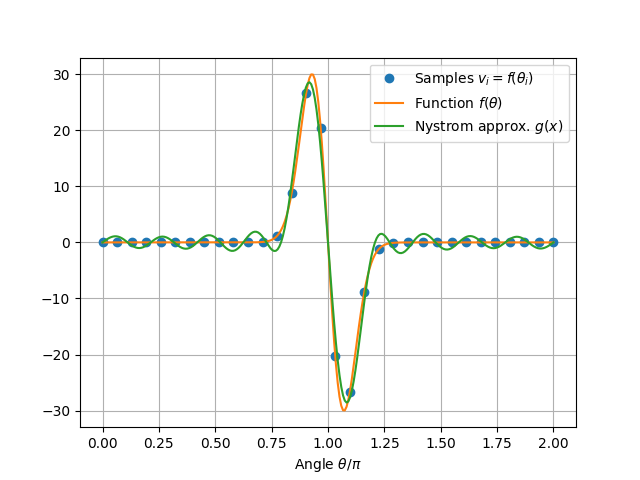

In [23]:
i_fig = 9

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig9, ax9 = plt.subplots(num=i_fig)
ax9.plot(thetas / jnp.pi, v, 'o',
         label='Samples $v_i = f(\\theta_i)$')
ax9.plot(thetas_plt / jnp.pi, f(thetas_plt), '-',
         label='Function $f(\\theta)$')
ax9.plot(thetas_plt / jnp.pi, jvmap(g)(xs_circle_plt), '-',
         label='Nystrom approx. $g(x)$')
ax9.set_xlabel('Angle $\\theta/\\pi$')
ax9.legend()
ax9.grid();

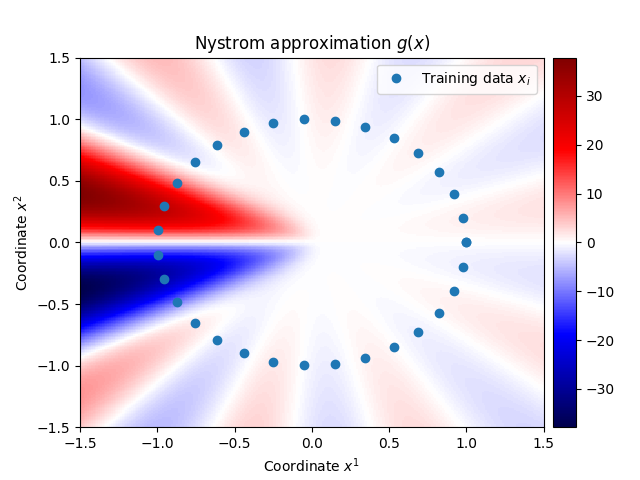

In [25]:
i_fig = 10

if plt.fignum_exists(i_fig):
    plt.close(i_fig)

fig10, ax10 = plt.subplots(num=i_fig)
ax10_divider = make_axes_locatable(ax10)
cax10 = ax10_divider.append_axes("right", size="5%", pad="2%")
im10 = ax10.pcolormesh(x1_plt, x2_plt, jvvmap(g)(xs_plt), cmap="seismic")
cb10 = fig10.colorbar(im10, cax=cax10)
ax10.plot(xs[:, 0], xs[:, 1], 'o', label='Training data $x_i$')
ax10.set_xlabel('Coordinate $x^1$')
ax10.set_ylabel('Coordinate $x^2$')
ax10.legend()
ax10.set_title('Nystrom approximation $g(x)$');